## Cumputer Vision
### Module 1. Image processing basics. Local image processing and feature descriptors

#### Task 1: Hough ('Huff') Transformations
    Write a function that converts image to Hough Space for line search and returns N (argument of the function) lines.
    Do not use ready functions from OpenCV. 
    Write convolution by yourself.
    
    
by Anastasiia Kasprova

    Link to Google Colab: https://colab.research.google.com/drive/1FubhPHgZfzczffDZficMd_pkinlEmEBj
    Link to github: https://github.com/kasprova/CV_UCU/tree/master/module1

    1. Canny Operator (Numpy)
    2. Hough Transform Development (Numpy)
    3*. Open CV realization (to check the results)
    4. Hough Transformation function
    
    References

In [ ]:
#libraries
import cv2
import numpy as np
import sys
from skimage import io
from numpy.linalg import inv
from google.colab.patches import cv2_imshow
#np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

In [ ]:
#! pip install opencv-python==4.1.0.25

In [ ]:
#from url to image
def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_RGB2GRAY)

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png


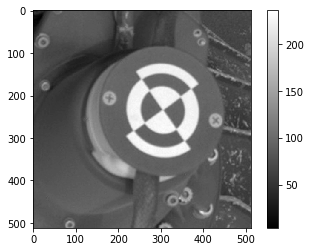

In [29]:
img = url_to_image("https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png")

plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [30]:
img.shape

(512, 512)

### 1. Canny Operator (Numpy)

    - gaussian 2D kernel
    - convolution 2D
    - image derivatives
    - non maximum suppression
    - double threshold
    - hysteresis

In [ ]:
def canny_operator(img, gaussian_kernel_size = 3, sigma = 1,
                      high_threshold_ratio=0.7, low_threshold_ratio=0.3,):
    
    
    #generate gaussian kernel
    def gaussian_2d_kernel(size, sigma=1):
        """
        Returns 2D Gaussian array
        (size x size kernel with Gaussian distribution defined by sigma value)
            g(x,y) = 1/(2*PI*sigma^2) * exp(-(x^2+y^2)/(2*sigma^2))
        """
        r = int(size) // 2 #half-size ~ radius
        x, y = np.meshgrid(np.linspace(-r,r,size), np.linspace(-r,r,size))
        g = 1 / (2.0 * np.pi * sigma**2) * np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
        g = g.astype(np.float32)

        return g
    
    
    #calculate 2d convolution
    def convolution_2d(img, kernel, stride = 1):
        """
        Convolve two 2-dimensional arrays
        Assumptions: 
            - no paddding, 
            - stride is the same for horizontal and vertical movings 
        Returns: 
            2d array containing a subset ot the discrete linear convolution of img and kernel
        """
        if not img.ndim == kernel.ndim == 2:
            raise ValueError('convolution_2d inputs must both be 2D arrays')

        img_h, img_w = img.shape
        kernel_h, kernel_w = kernel.shape
        stride = np.int32(stride)

        #output_hight = (img_hight - filter_hight)/stride +1
        conv_output_h = np.int32((img_h - kernel_h)/stride + 1)
        #output_width = (img_width - filter_width)/stride +1
        conv_output_w = np.int32((img_w - kernel_w)/stride + 1)
        conv_output = np.zeros((conv_output_h,conv_output_w), dtype=np.int32)


        #convolution
        for i, row in enumerate(conv_output):
            for j, pixel in enumerate(row):
                conv_output[i][j] = np.sum(img[i:i+kernel_h, j:j+kernel_w]*kernel)

        return conv_output
        
    
    #calculate image derivatives
    def image_derivatives(img):
        """
        Returns: 1) Magnitude of gradient: ||I||=sqrt((dI/dx)^2+(dI/dy)^2)  - uniform
                 2) Edge direction: theta = arctg(dI/dy // dI/dx)
                 3) Horizontal edge detection: dI/dx
                 4) Vertical edge detection: dI/dy
        """
        #Image derivatives
        # Horizontal edge detection: dI/dx
        kernel_h = np.array([[-1, 1]])
        img_h = convolution_2d(img, kernel_h)
        img_h = img_h[:np.min(img_h.shape),:np.min(img_h.shape)]

        # Vertical edge detection: dI/dy
        kernel_v = np.array([[-1],[ 1]])
        img_v = convolution_2d(img, kernel_v)
        img_v = img_v[:np.min(img_v.shape),:np.min(img_v.shape)]

        #intensity gradient: ||I||=sqrt((dI/dx)^2+(dI/dy)^2)
        img_I = np.sqrt(img_h * img_h + img_v * img_v)
        #img_I = np.hypot(img_h,img_v)

        #make uniform: [0,255]
        img_I_uniform = img_I/img_I.max()*255

        #theta = arctg(dI/dy // dI/dx)
        theta = np.arctan2(img_v,img_h)

        return img_I_uniform, theta, img_h, img_v
    
    
    
    def non_max_suppression(img, angle_radians):
        
        img_h, img_w = img.shape
        #initialization of output array
        img_nms = np.zeros((img_h, img_w), dtype=np.int32)
        #transfer radians into angles
        angle_degrees = angle_radians * 180 / np.pi
        angle_degrees[angle_degrees < 0] += 360

        for i in range(1, img_h-1):
            for j in range(1, img_w-1):
                #assigning value to r and q depending on angle
                #0, 180
                if (0 <= angle_degrees[i,j] < 22.5) or ((180-22.5) <= angle_degrees[i,j] < (180+22.5)) or ((360-22.5) <= angle_degrees[i,j] < 360):
                    q = img[i][j-1]
                    r = img[i][j+1]
                #45, 225
                elif (22.5 <= angle_degrees[i,j] < (90-22.5)) or ((180+22.5) <= angle_degrees[i,j] < (270-22.5)):
                    q = img[i+1][j-1]
                    r = img[i-1][j+1]
                #90, 270
                elif ((90-22.5) <= angle_degrees[i,j] < (90+22.5)) or ((270-22.5) <= angle_degrees[i,j] < (270+22.5)):
                    q = img[i+1][j]
                    r = img[i-1][j]
                #135, 315
                elif ((90+22.5) <= angle_degrees[i,j] < (180-22.5)) or ((270+22.5) <= angle_degrees[i,j] < (360-22.5)):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                #compare the intensity of p with q and r
                if (img[i,j] >= q) and (img[i,j] >= r):
                    img_nms[i,j] = img[i,j]
                else:
                    img_nms[i,j] = 0

        return img_nms

    def double_threshold(img, high_threshold_ratio=0.7, low_threshold_ratio=0.3,
                    weak_value = 100, strong_value = 255):
        """
            Returns 2D array, 
                where pixels with values > high_threshold_ratio*img.max() are replaced with strong_value, 
                pixels with values < high_threshold_ratio*img.max()*low_threshold_ratio are replaced with 0,
                pixels with values in between both thresholds are replaced with weak_value
        """

        high_threshold = img.max() * high_threshold_ratio #178.5 - uniform, 19
        low_threshold = high_threshold * low_threshold_ratio #89.25 - uniform, 5

        #initialization of output array
        img_dt = np.zeros(img.shape, dtype=np.int32)

        #weak_value = np.int32(weak_value)
        #strong_value = np.int32(strong_value)

        #strong pixels location
        strong_i, strong_j = np.where(img >= high_threshold)
        #strong pixels new value assignment
        img_dt[strong_i, strong_j] = strong_value

        #weak pixels location
        weak_i, weak_j = np.where((img <= high_threshold) & (img >= low_threshold))
        #weak pixels new value assignment
        img_dt[weak_i, weak_j] = weak_value

        # no need to assign value for i,j where img < low_threshold, since it is 0 from the initialization

        return img_dt
    
    
    def hysteresis(img, strong = 255, weak = 100):
        """
            Returns 2D array.
                Checking whether any of the neighbours of the current pixel is a strong one. 
                If it is then the current pixel is strong too.
        """

        img_h, img_w = img.shape
        #initialization of output array
        img_hyst = np.zeros((img_h, img_w), dtype=np.int32)

        for i in range(1, img_h-1):
            for j in range(1, img_w-1):
                if (img[i,j] == strong):
                    img_hyst[i, j] = strong
                elif (img[i,j] == weak):
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img_hyst[i, j] = strong
                    else:
                        img_hyst[i, j] = 0
        return img_hyst
    
    #assignments
    kernel = gaussian_2d_kernel(size = gaussian_kernel_size, sigma = sigma)
    convolution_output = convolution_2d(img = img, kernel = kernel)
    img_I_uniform, theta, img_h, img_v = image_derivatives(img = convolution_output)
    img_nms = non_max_suppression(img = img_I_uniform, angle_radians = theta)
    img_dt = double_threshold(img = img_nms)
    img_hyst = hysteresis(img = img_dt, strong = 255, weak = 100)
    
    return img_hyst

In [32]:
#original image
img = url_to_image("https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png")
#canny operator applied to the image
img_canny = canny_operator(img)

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png


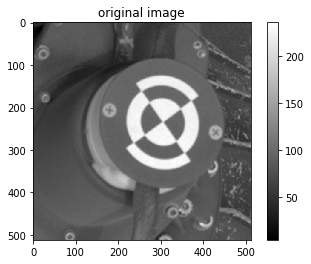

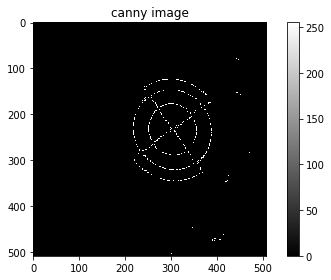

In [33]:
#visualization
plt.figure(1)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.title("original image")

plt.figure(2)
plt.imshow(img_canny, cmap='gray')
plt.colorbar()
plt.title("canny image")

plt.tight_layout()
plt.show()

------

#### Check with OpenCV having the same parameters

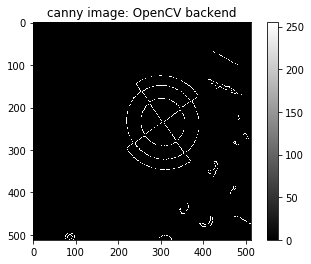

In [41]:
#Canny realization using OpenCV
#find edges using canny detector
img_canny_cv2 = cv2.Canny(image = img,
                  threshold1 = 90, #max(I)*0.7*0.3
                  threshold2 = 180, #max(I)*0.7
                  L2gradient = True
                )

plt.imshow(img_canny_cv2, cmap='gray')
plt.colorbar()
plt.title("canny image: OpenCV backend")
plt.show()

------

### 2. Hough Transform

    A line on an image corresponds to a point in Hough space
    y0 = m*x0 + b   ->   b = - x0*m + y0
    y1 = m*x1 + b   ->   b = - x1*m + y1
    
NB!: a vertical line is very painful, having slope of infinity
Thus we use polar representation of the lines:

    x * cos(theta) + y * sin(theta) = d
        - d: perpendcular distance from line to origin
        - theta: angle the perpendicular makes with the x-axis

Hough Accumulator Array - keeps the votes
We need to decide how big bins are. PI = 180 bins

  **Algorithm**:
  
      1. Initialize H[d,theta] = 0
      2. For each edge point in E(x,y) in the image for theta = 0..180,
      d = x*cos(theta)- y*sin(theta) #can be negative
      H[d, theta]+=1
      3. Find values of (d, theta) where H[d, theta] is maximum
      4. Detect the line in the image is given by polar representation
      d = x*cos(theta)- y*sin(theta)

    
Space complaxity:
1) k^n bins
2) voting ~ line points = constant

---------
Number of theta: [0,180] - when thetais more than 180 - r turns to be negative
Number of r: diagonal length of the image

In [ ]:
#assigning value from Canny operation
image = img_canny[:]

#calculate for each i,j pair (where pixel value = 255) 
#the values of rho having theta in range (0,180, step = 1)
dict_values_transformation = {}

for i, row in enumerate(image):
    for j, value in enumerate(row):
        if (value == 255):
            rho_list = []
            theta_list = []
            for theta in np.linspace(0, np.pi,181):
                rho = i*np.cos(theta)-j*np.sin(theta)
                rho_list.append(rho)
                theta_list.append(theta)
        
            dict_values_transformation[(i,j)] = [theta_list, rho_list, np.int32(np.linspace(0, 180, 181))]


#min and max values of the rho
all_possible_rho_list = []

for key, value in dict_values_transformation.items():
    all_possible_rho_list.extend(value[1])

#indexes for Hough Space matrix: adding absolute value of rho_min to have indexing starting from 0
min_rho, max_rho = min(np.int32(all_possible_rho_list)), max(np.int32(all_possible_rho_list))
rho_index = np.linspace(0, abs(min_rho) + max_rho , (abs(min_rho) + max_rho + 1))
theta_index = np.linspace(0,180,181)

#initialization of Hough Accumulator Array
H = np.zeros((len(rho_index), len(theta_index)), dtype=np.int32)

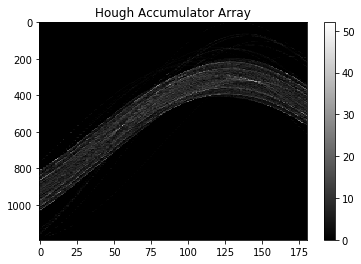

In [35]:
#voting
for key, value in dict_values_transformation.items():
    theta_degree = value[2]
    rho_plus_abs_rho_min = np.int32(value[1]+abs(min_rho))
    H[rho_plus_abs_rho_min,theta_degree]+=1

plt.imshow(H, cmap='gray',  aspect='auto')
plt.colorbar()
plt.title("Hough Accumulator Array")
plt.show()

In [ ]:
#top min_number_of_lines values of pixel intensity
min_number_of_lines = 2

In [ ]:
#list indexes with top min_number_of_lines values of pixel intensity
rho_max_list = []
theta_max_list = []
for i in sorted(np.unique(np.int32(H))[-min_number_of_lines:], reverse=True):
    rho_max, theta_max = np.where(H == i)
    rho_max_list.extend(rho_max-abs(min_rho)) # substruct abs(min_rho)
    theta_max_list.extend(theta_max)

downloading https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png
Coefficients of the line y=a*x+b, which goes through the following points  (0, 140)  and  (509, 496) :
a = 0.6994106
b = 140
Coefficients of the line y=a*x+b, which goes through the following points  (0, 624)  and  (509, -76) :
a = -1.3752456
b = 624
Coefficients of the line y=a*x+b, which goes through the following points  (0, 141)  and  (509, 498) :
a = 0.70137525
b = 141


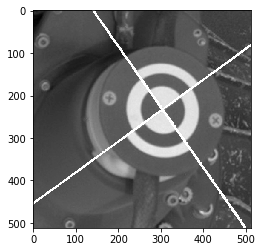

In [39]:
image_ = url_to_image("https://raw.githubusercontent.com/felistrs/ucu-cv-code/master/res/marker_cut_rgb_512.png")
#plot results
for rho,theta in zip(rho_max_list,theta_max_list):
    # y = a*x + b
    #minX
    x1 = 0
    y1 = np.int32((x1*np.cos(theta*np.pi/180)-rho)/np.sin(theta*np.pi/180))
    b = y1
    #minY
    x2 = image.shape[1]
    y2 = np.int32((x2*np.cos(theta*np.pi/180)-rho)/np.sin(theta*np.pi/180))
    a = np.float32((y2 - b)/x2)
    cv2.line(image_,(y1,x1), (y2,x2), (255, 0, 0), 3)
    print("Coefficients of the line y=a*x+b, which goes through the following points ", (x1, y1), " and ", (x2, y2), ":")
    print("a =", a)
    print("b =", b)
plt.imshow(image_, cmap='gray')
plt.show()

-----

#### Check with OpenCV (probabilistic approach) 

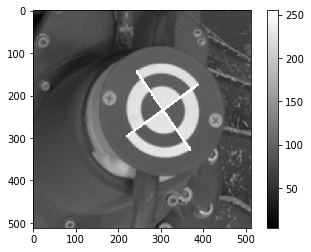

In [42]:
# Find the edges in the image using canny detector
edges = cv2.Canny(image = img,
                  threshold1 = 90, #max(I)*0.7*0.3
                  threshold2 = 180, #max(I)*0.7
                  L2gradient = True
                )
#Progressive Probabilistic Hough Transform
#Detect points that form a line
lines = cv2.HoughLinesP(image = edges, 
                        rho = 1, 
                        theta = np.pi/180, 
                        threshold = 50, 
                        minLineLength=100, 
                        maxLineGap=35
                       )
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

____

### 4. Hough Transformation Function

The same as above but function

In [ ]:
def hough_transformation(img, min_number_of_lines):
    
    #applying canny operator
    img_canny = canny_operator(img)
    
    #calculate for each i,j pair (where pixel value = 255) the values of rho having theta in range (0,180, step = 1
    dict_values_transformation = {}

    for i, row in enumerate(image):
        for j, value in enumerate(row):
            if (value == 255):
                rho_list = []
                theta_list = []
                for theta in np.linspace(0, np.pi,181):
                    rho = i*np.cos(theta)-j*np.sin(theta)
                    rho_list.append(rho)
                    theta_list.append(theta)

                dict_values_transformation[(i,j)] = [theta_list, rho_list, np.int32(np.linspace(0, 180, 181))]


    #min and max values of the rho
    all_possible_rho_list = []

    for key, value in dict_values_transformation.items():
        all_possible_rho_list.extend(value[1])

    #indexes for Hough Space matrix: adding absolute value of rho_min to have indexing starting from 0
    min_rho, max_rho = min(np.int32(all_possible_rho_list)), max(np.int32(all_possible_rho_list))
    rho_index = np.linspace(0, abs(min_rho) + max_rho , (abs(min_rho) + max_rho + 1))
    theta_index = np.linspace(0,180,181)

    #initialization of Hough Accumulator Array
    H = np.zeros((len(rho_index), len(theta_index)), dtype=np.int32)
    
    
    #voting
    for key, value in dict_values_transformation.items():
        theta_degree = value[2]
        rho_plus_abs_rho_min = np.int32(value[1]+abs(min_rho))
        H[rho_plus_abs_rho_min,theta_degree]+=1

    
    #list indexes with top min_number_of_lines valuesof pixel intensity
    rho_max_list = []
    theta_max_list = []
    for i in sorted(np.unique(np.int32(H))[-min_number_of_lines:], reverse=True):
        rho_max, theta_max = np.where(H == i)
        rho_max_list.extend(rho_max-abs(min_rho)) # substruct abs(min_rho)
        theta_max_list.extend(theta_max)
        
    #plot results
    for rho,theta in zip(rho_max_list,theta_max_list):
        # y = a*x + b
        #minX
        x1 = 0
        y1 = np.int32((x1*np.cos(theta*np.pi/180)-rho)/np.sin(theta*np.pi/180))
        b = y1
        #minY
        x2 = img.shape[1]
        y2 = np.int32((x2*np.cos(theta*np.pi/180)-rho)/np.sin(theta*np.pi/180))
        a = np.float32((y2 - b)/x2)
        cv2.line(img,(y1,x1), (y2,x2), (255, 0, 0), 3)
        print("Coefficients of the line y=a*x+b, which goes through the following points ", (x1, y1), " and ", (x2, y2), ":")
        print("a =", a)
        print("b =", b)
     
    return img, plt.imshow(img, cmap='gray')

Coefficients of the line y=a*x+b, which goes through the following points  (0, 140)  and  (512, 498) :
a = 0.69921875
b = 140
Coefficients of the line y=a*x+b, which goes through the following points  (0, 624)  and  (512, -80) :
a = -1.375
b = 624
Coefficients of the line y=a*x+b, which goes through the following points  (0, 141)  and  (512, 500) :
a = 0.7011719
b = 141


(array([[49, 39, 33, ..., 68, 70, 71],
        [54, 45, 39, ..., 69, 72, 74],
        [62, 52, 46, ..., 69, 72, 78],
        ...,
        [92, 92, 91, ..., 78, 82, 81],
        [92, 92, 91, ..., 78, 82, 82],
        [92, 92, 92, ..., 79, 83, 90]], dtype=uint8),
 <matplotlib.image.AxesImage at 0x7f8132f5ea20>)

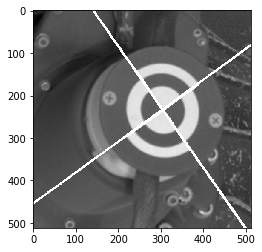

In [47]:
hough_transformation(img, min_number_of_lines=2)

#### References

Canny Operator:

    1. https://docs.google.com/presentation/d/1pCzSJ_52lCXg_MWssyajJPmQv-JJ93lm5y66hF1G9oo/edit#slide=id.g578295c1bc_0_4
    2. https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
    3. https://en.wikipedia.org/wiki/Image_gradient
    4. http://juanreyero.com/article/python/python-convolution.html
    5. https://stackoverflow.com/questions/20036663/understanding-numpys-convolve
    6. https://en.wikipedia.org/wiki/Canny_edge_detector
    7. http://justin-liang.com/tutorials/canny/#gradient

Hough Space:

    1. https://classroom.udacity.com/courses/ud810/lessons/2870588566/concepts/34824487890923 - theory
    2. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html - explanation of the algorithm
